In [ ]:
from src.torch_erg import load_pglib_opf as lp
from src.torch_erg.utils import laplacian_matrix
from src.torch_erg.samplers import GWGSampler, MHSampler
import torch
import numpy as np
import networkx as nx
import random as rnd

from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
# parsing the .m file into a suitable format, and perform some sanity checks
import matplotlib.pyplot as plt

from plots import *
from graph_generators import *
from param_estimation import *
from other_g_stats import *

In [3]:
name = '30_ieee'
SOFT_CONN = True

ordmat, ordlist, buslist, countlist = lp.pow_parser(name)

ordmat = torch.tensor(ordmat)
ordlist = torch.tensor(ordlist)
buslist = torch.tensor(buslist)
countlist = torch.tensor(countlist)

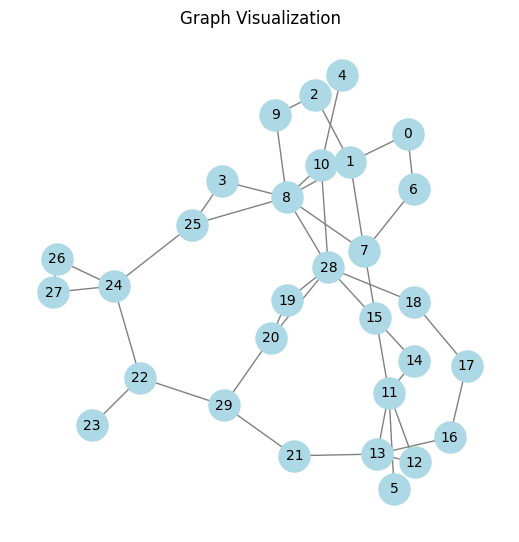

In [15]:
plot_graph(ordmat)

In [5]:
class MySampler(MHSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        ac = torch.linalg.eigvalsh(laplacian_matrix(mtx))[1]
        avg_degree = torch.sum(mtx, dim=1).mean()
        avg_clustering = avg_clustering_coeff(mtx)

        return(torch.stack([edges, triangles, ac, avg_degree, avg_clustering]))

betas = torch.tensor([0., 0., 0., 0., 0.], dtype=float)


alpha = 0.002
niter = 120000
min_change = 0.001
update_steps = 3

sampler = MySampler(backend="cuda")
obs = sampler.observables(ordmat)

params, graphs = sampler.param_run(graph=ordmat,
                      observables=obs,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

CUDA backend not available falling back to cpu


  0%|          | 0/120000 [00:00<?, ?it/s]

100%|██████████| 120000/120000 [02:23<00:00, 834.39it/s] 

number of accepted steps is:  31784
number of rejected samples:  88216
number of effective updates is:  10594


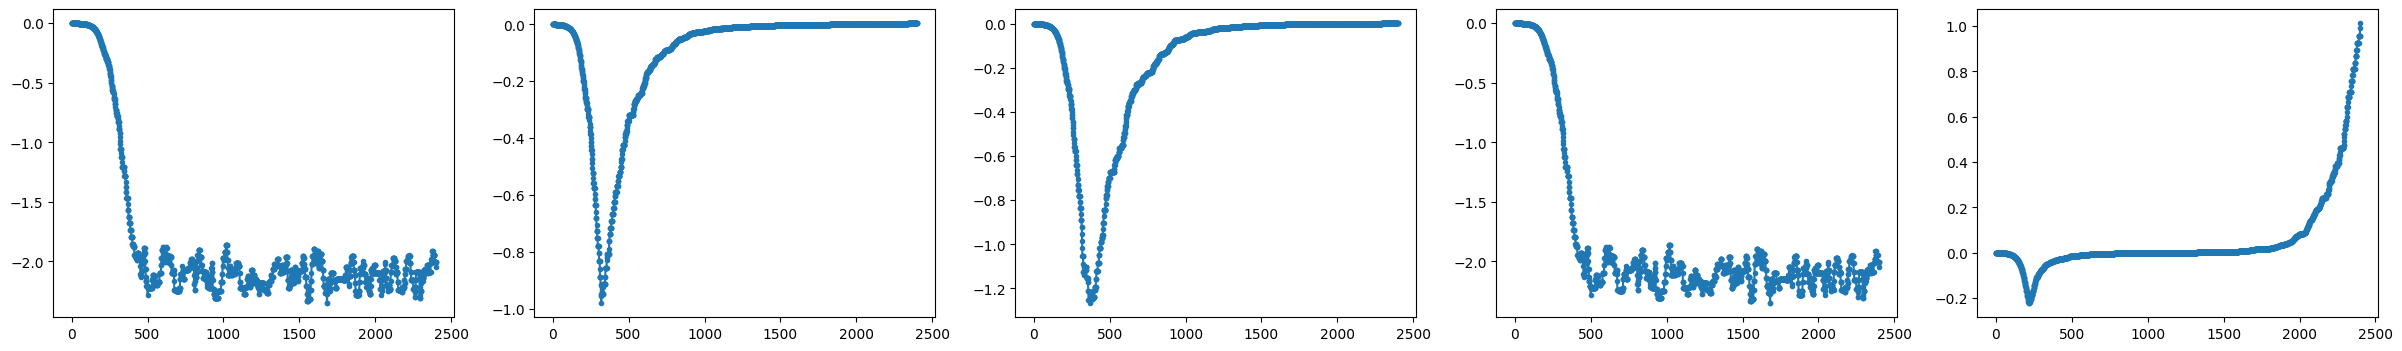

In [6]:
plot_params_iterations(params)

In [7]:
params_for_estimates = torch.stack(params[-100:]).mean(axis = 0)
# run in sample mode, without parameter modifications
observables, graphs = sampler.sample_run(graph=ordmat,
                      observables=obs,
                      params=params_for_estimates,
                      niter=niter,
                      save_every=50)

100%|██████████| 120000/120000 [02:20<00:00, 856.99it/s] 


number of accepted steps is:  24165
number of rejected samples:  95835
Mean obs:  tensor([43.6091,  4.2251,  0.0841,  2.9073,  0.0527], dtype=torch.float64)


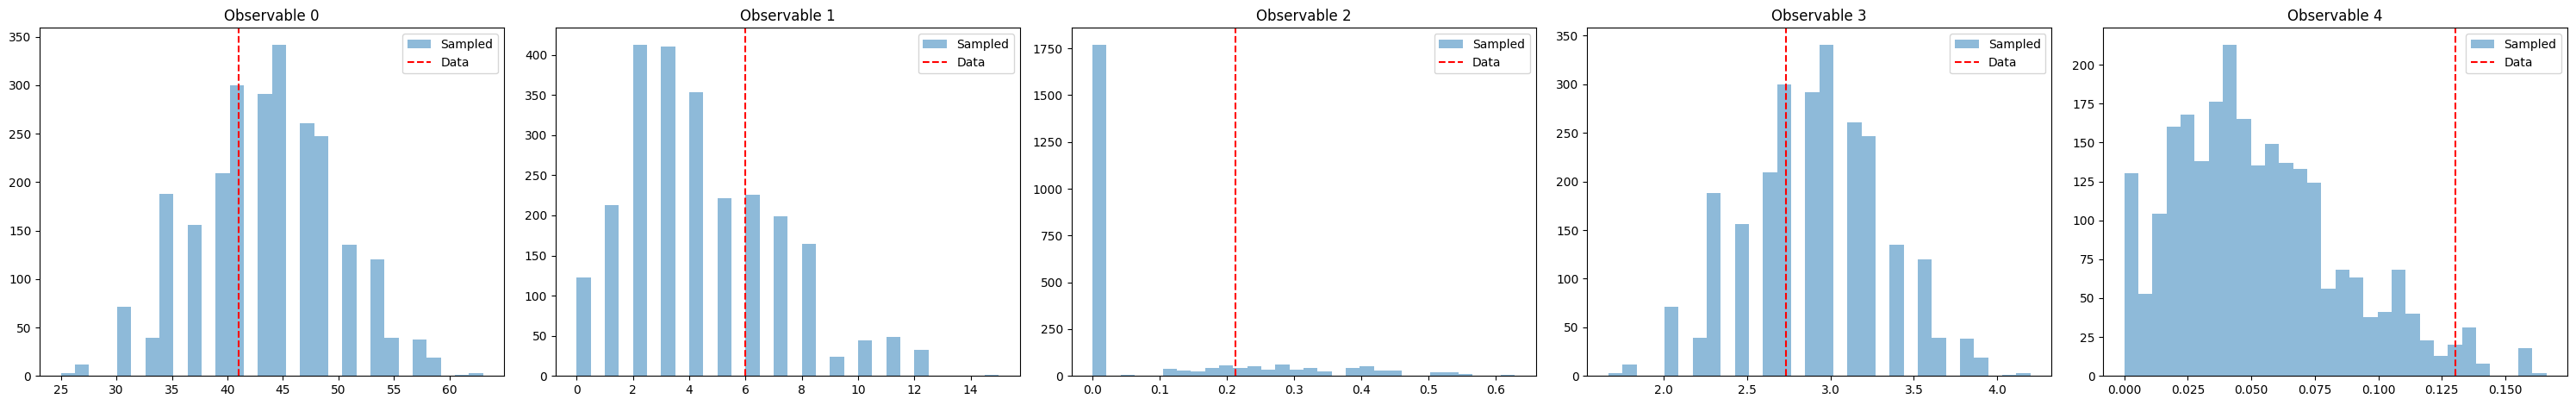

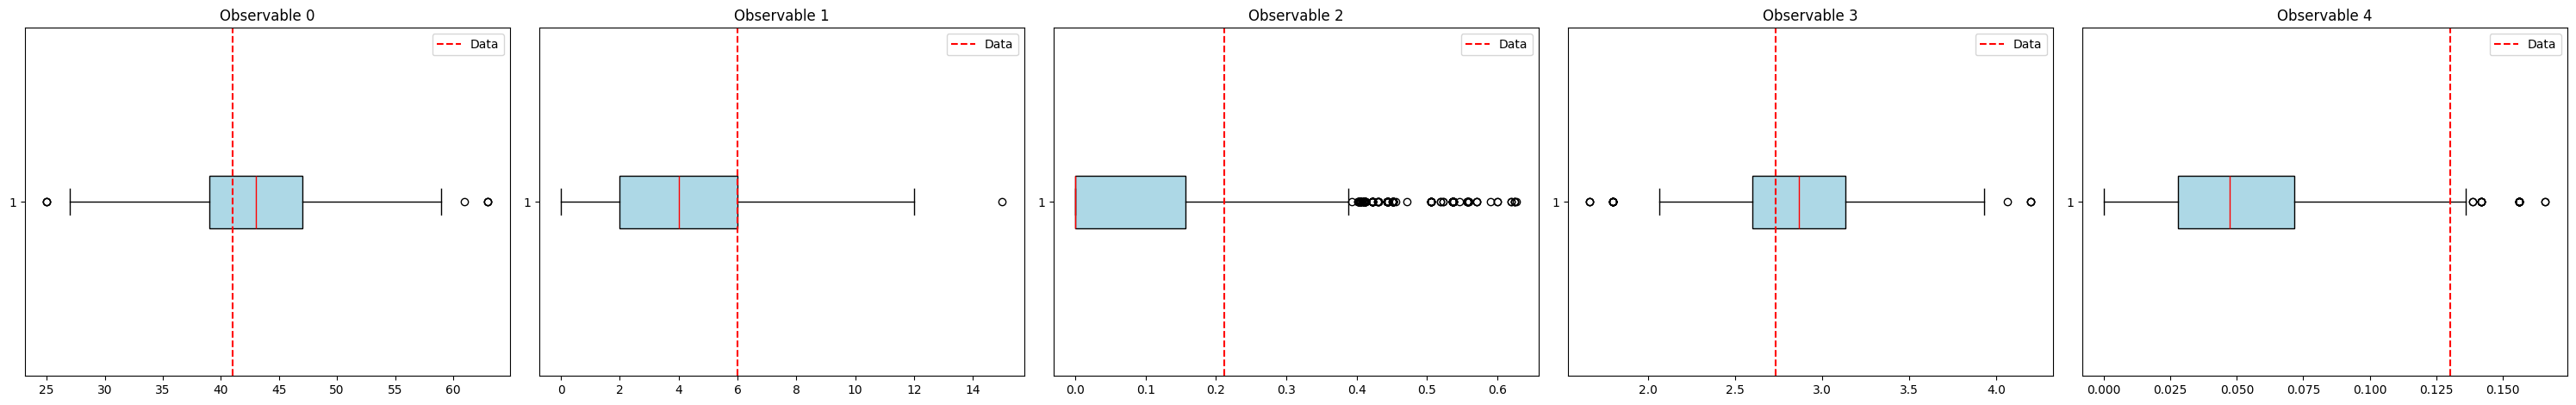

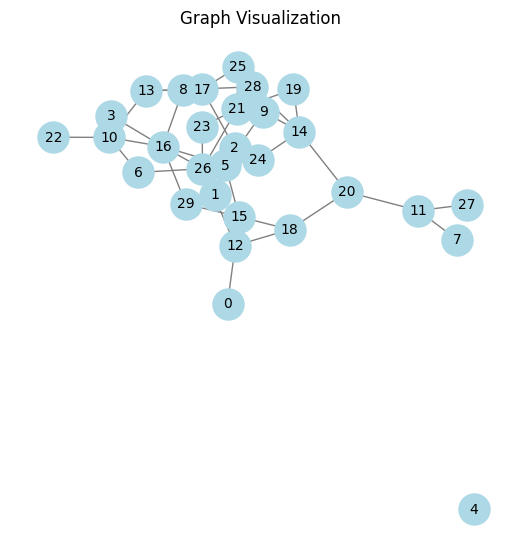

In [9]:
hist_obs_samples(observables, obs)
boxplot_obs_samples(observables, obs)
plot_graph(graphs[-1])

In [15]:
connected_graphs = [g for g in graphs if connected_components(csr_matrix(g.numpy()))[0] <= 2]
connected_observables = [sampler.observables(g) for g in connected_graphs]
len(connected_graphs)

1475

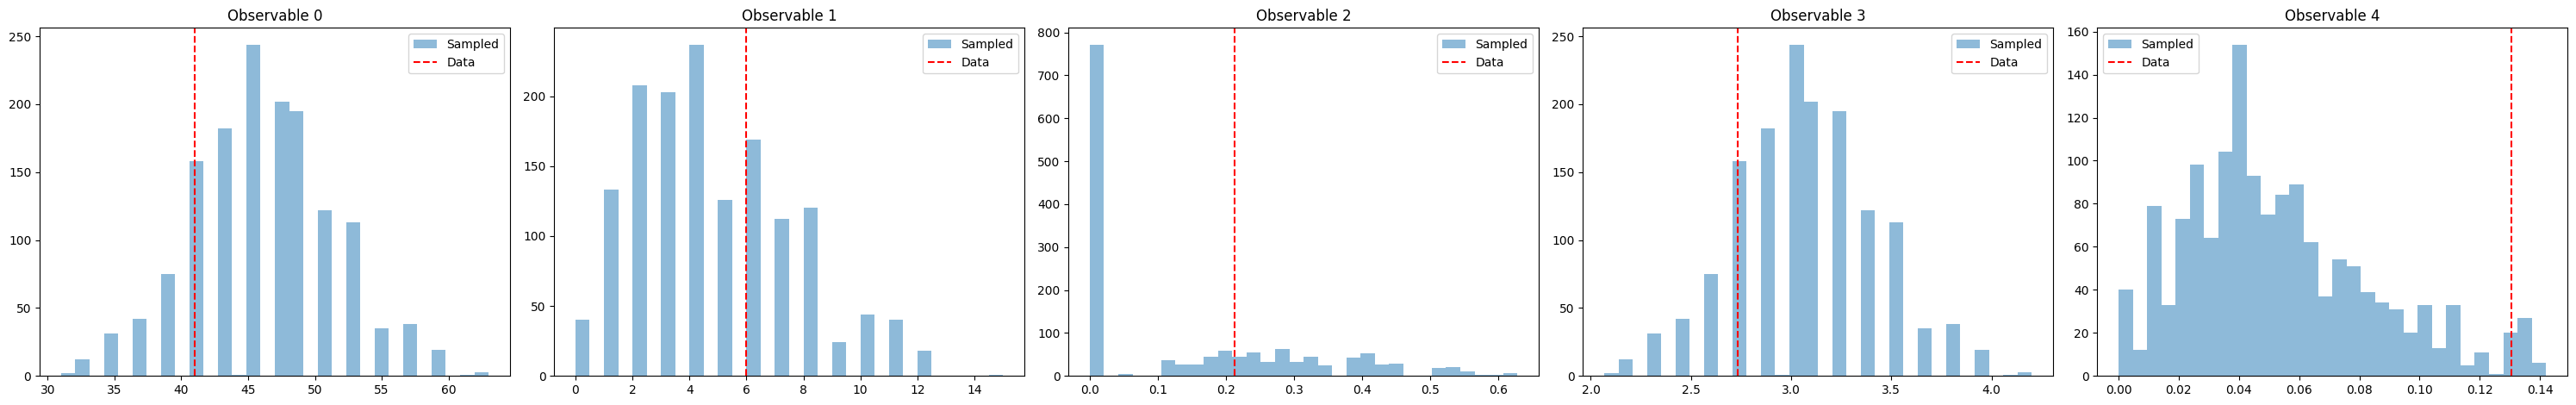

In [17]:
hist_obs_samples(connected_observables, obs)

---

In [41]:
class MySampler2(GWGSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        ac = torch.linalg.eigvalsh(laplacian_matrix(mtx))[1]
        avg_degree = torch.sum(mtx, dim=1).mean()
        avg_clustering = avg_clustering_coeff(mtx)

        return(torch.stack([edges, triangles, ac, avg_degree, avg_clustering]))

betas = torch.tensor([0., 0., 0., 0., 0.], dtype=float)

sampler2 = MySampler2(backend="cuda")
obs = sampler.observables(ordmat)

params, graphs = sampler.param_run(graph=ordmat,
                      observables=obs,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

CUDA backend not available falling back to cpu


100%|██████████| 100000/100000 [02:00<00:00, 829.30it/s]

number of accepted steps is:  27869
number of rejected samples:  72131
number of effective updates is:  9289


In [42]:
params_for_estimates = torch.stack(params[-100:]).mean(axis = 0)
# run in sample mode, without parameter modifications
observables, graphs = sampler2.sample_run(graph=ordmat,
                      observables=obs,
                      params=params_for_estimates,
                      niter=niter,
                      save_every=50)

100%|██████████| 100000/100000 [07:52<00:00, 211.54it/s]


number of accepted steps is:  99537
number of rejected samples:  463
Mean obs:  tensor([42.4883,  3.7619,  0.0675,  2.8326,  0.0478], dtype=torch.float64)


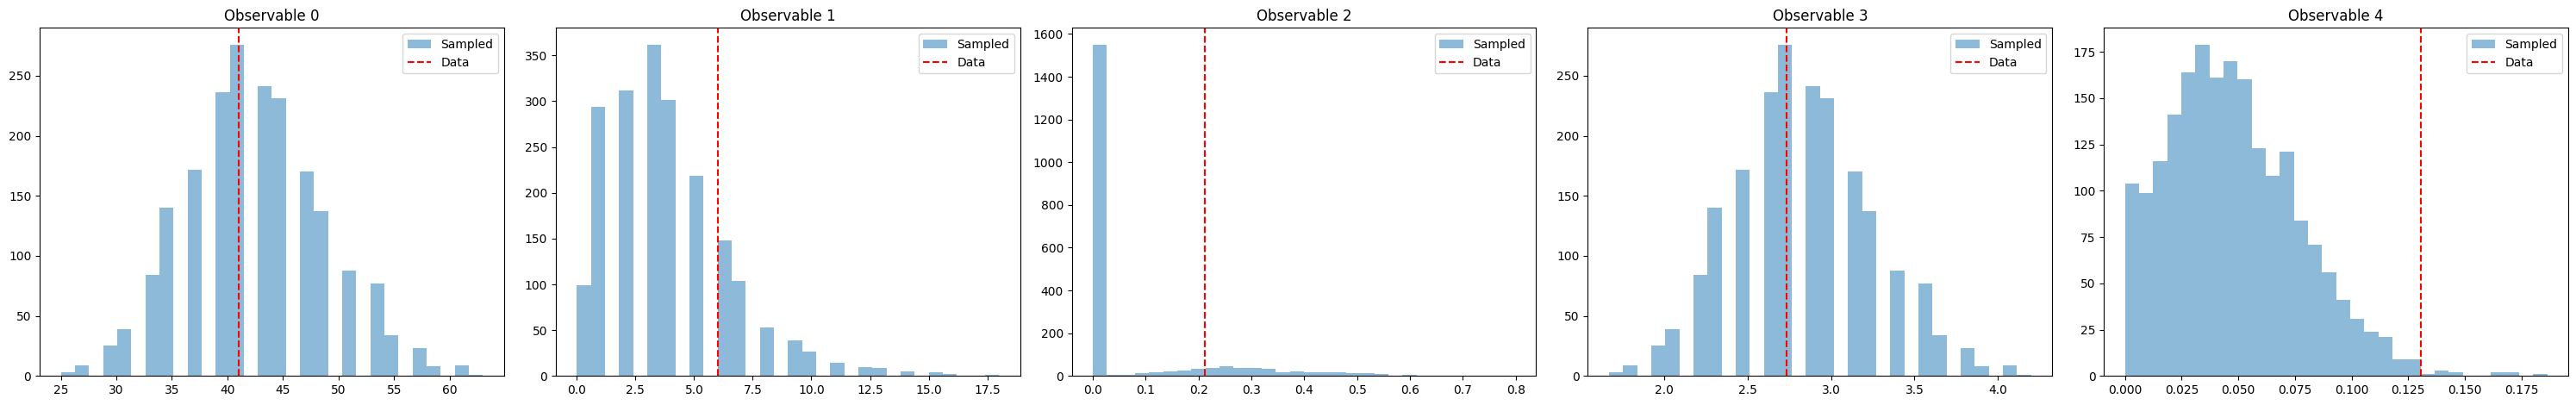

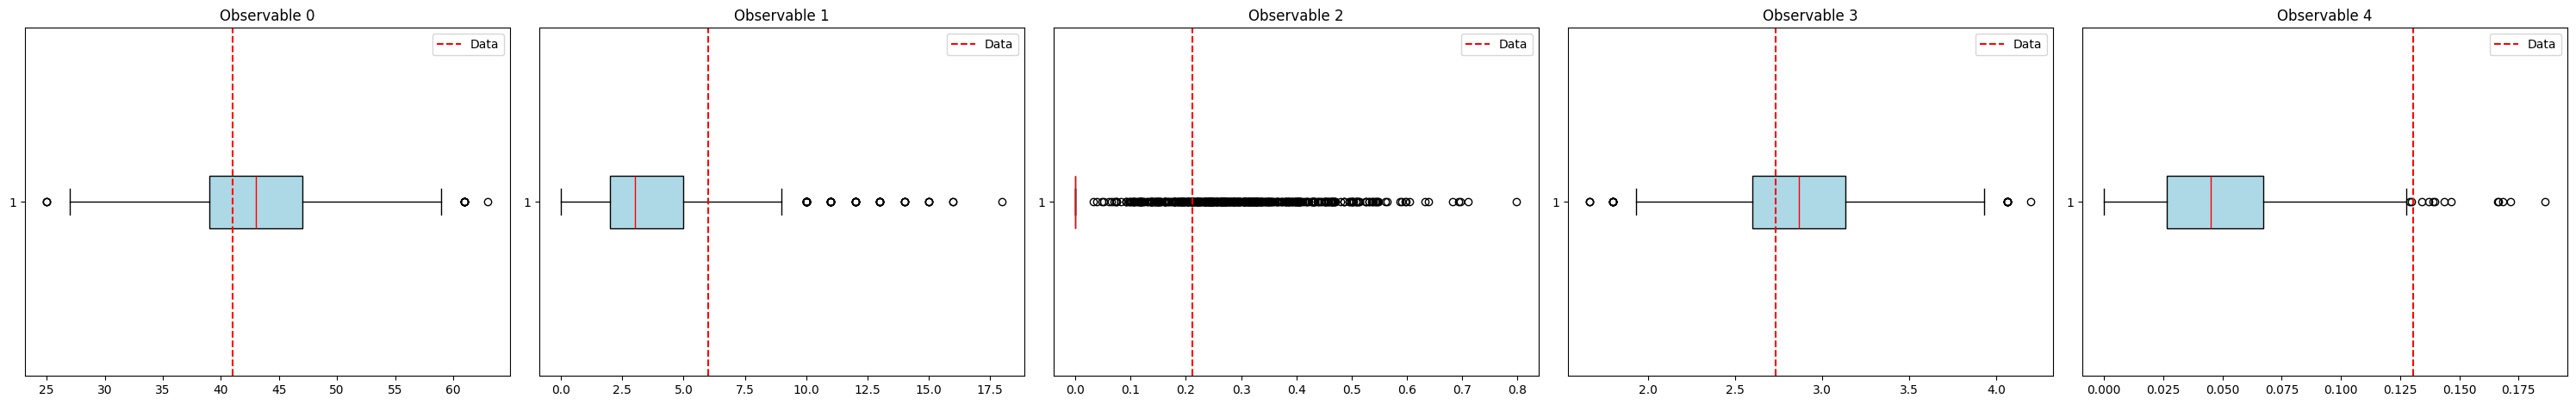

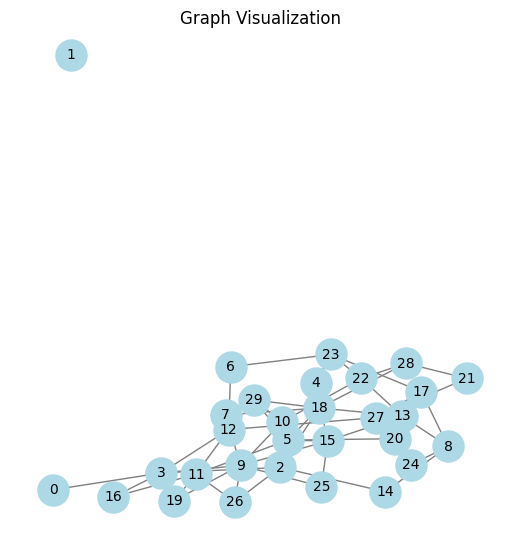

In [43]:
hist_obs_samples(observables, obs)
boxplot_obs_samples(observables, obs)
plot_graph(graphs[-1])